In [ ]:
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

In [ ]:
import pyspark
from pyspark.sql import SparkSession
from pyspark import SparkContext
import pyspark.sql.functions as F
from pyspark.sql.functions import *
from itertools import *
import pandas as pd
from pandas.plotting import scatter_matrix

In [ ]:
spark = SparkSession.builder.appName('MachineLearning').getOrCreate()

In [ ]:
data = spark.read.csv('/content/drive/MyDrive/datasetYouTubeNetwork.csv', header = True, inferSchema = True)
inputFeatures = [ t for t in data.columns if t.startswith(("outbandQoS", "pcapStats_stats", "totalDuration", "totalPacketCount", "QoE_ITU_046"))]
inputFeaturesReg = [ t for t in data.columns if t.startswith(("outbandQoS", "pcapStats_stats", "totalDuration", "totalPacketCount"))]
data.show()

+-----------+----------------+-------------+-------------+-------------+-------------+-------------+--------------+---------+--------------+------------------+----------------+----------------+--------------+------------------+---------------+-------------------------+------------------------+------------------------+--------------------------+-------------------------+------------------------+------------------------+--------------------------+-------------------------+------------------------+------------------------+--------------------------+-------------------------+------------------------+------------------------+--------------------------+-------------------------+------------------------+------------------------+--------------------------+-------------------------+------------------------+------------------------+--------------------------+-------------------------+------------------------+------------------------+--------------------------+-------------------------+----------

# **Question 01 (Regression Modeling):**

In [ ]:
# Question 1.1 :Plot the correlation matrix (correlogram) of the dataset.
# Only use the input features as shown on the previous page and use “QoE_ITU_046”

from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

vector_col = "features"
assembler = VectorAssembler(inputCols=inputFeatures, outputCol=vector_col)
df_vector = assembler.transform(data).select(["features"])
matrix = Correlation.corr(df_vector, vector_col).collect()[0][0]
print(matrix)


DenseMatrix([[ 1.        ,  0.48294173, -0.22785576, ..., -0.16556781,
               0.39913913,  0.52622611],
             [ 0.48294173,  1.        , -0.14046314, ..., -0.0873799 ,
               0.21016468,  0.28104103],
             [-0.22785576, -0.14046314,  1.        , ...,  0.07512676,
              -0.18744367, -0.28355518],
             ...,
             [-0.16556781, -0.0873799 ,  0.07512676, ...,  1.        ,
               0.50056487, -0.05347802],
             [ 0.39913913,  0.21016468, -0.18744367, ...,  0.50056487,
               1.        ,  0.45899194],
             [ 0.52622611,  0.28104103, -0.28355518, ..., -0.05347802,
               0.45899194,  1.        ]])


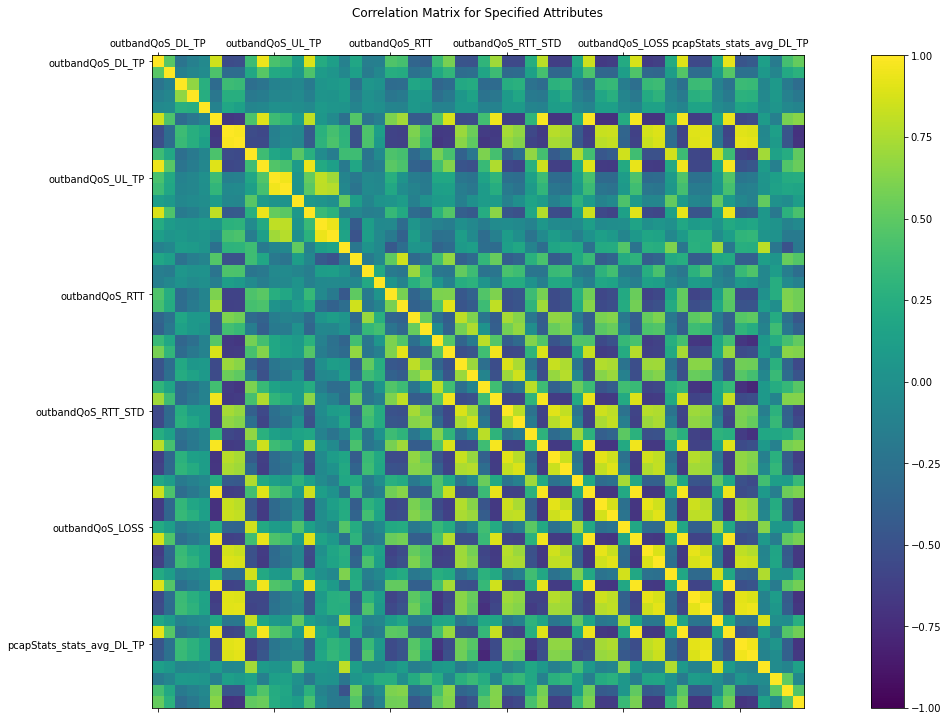

In [ ]:
import matplotlib.pyplot as plt
attr = inputFeatures
correlations = matrix.toArray().tolist()

fig=plt.figure(figsize=(24,12))
ax=fig.add_subplot(111)
ax.set_title("Correlation Matrix for Specified Attributes")
ax.set_xticklabels(['']+attr)
ax.set_yticklabels(['']+attr)
cax=ax.matshow(correlations, vmax=1, vmin=-1)
fig.colorbar(cax)
plt.show()


In [ ]:
# Which features have the highest correlation with QoE_ITU_046?
matrix = Correlation.corr(df_vector, vector_col)
result = matrix.collect()[0]["pearson({})".format(vector_col)].values
max_corr = pd.DataFrame(result.reshape(-1, len(inputFeatures)), columns=inputFeatures, index=inputFeatures)
print("Highest correlation value with QoE_ITU_046 : ", sorted(max_corr["QoE_ITU_046"], reverse=True)[0:3])
high_corr = max_corr["QoE_ITU_046"] == sorted(max_corr["QoE_ITU_046"], reverse=True)[1]
max_corr[high_corr]

Highest correlation value with QoE_ITU_046 :  [1.0, 0.6439782979704319, 0.6273712106796966]


,outbandQoS_DL_TP,outbandQoS_UL_TP,outbandQoS_RTT,outbandQoS_RTT_STD,outbandQoS_LOSS,pcapStats_stats_avg_DL_TP,pcapStats_stats_avg_UL_t,pcapStats_stats_avg_DL_t,pcapStats_stats_avg_DL_pkt,pcapStats_stats_max_DL_TP,pcapStats_stats_max_UL_t,pcapStats_stats_max_DL_t,pcapStats_stats_max_DL_pkt,pcapStats_stats_std_DL_TP,pcapStats_stats_std_UL_t,pcapStats_stats_std_DL_t,pcapStats_stats_std_DL_pkt,pcapStats_stats_p10_DL_TP,pcapStats_stats_p10_UL_t,pcapStats_stats_p10_DL_t,pcapStats_stats_p10_DL_pkt,pcapStats_stats_p20_DL_TP,pcapStats_stats_p20_UL_t,pcapStats_stats_p20_DL_t,pcapStats_stats_p20_DL_pkt,pcapStats_stats_p30_DL_TP,pcapStats_stats_p30_UL_t,pcapStats_stats_p30_DL_t,pcapStats_stats_p30_DL_pkt,pcapStats_stats_p40_DL_TP,pcapStats_stats_p40_UL_t,pcapStats_stats_p40_DL_t,pcapStats_stats_p40_DL_pkt,pcapStats_stats_p50_DL_TP,pcapStats_stats_p50_UL_t,pcapStats_stats_p50_DL_t,pcapStats_stats_p50_DL_pkt,pcapStats_stats_p60_DL_TP,pcapStats_stats_p60_UL_t,pcapStats_stats_p60_DL_t,pcapStats_stats_p60_DL_pkt,pcapStats_stats_p70_DL_TP,pcapStats_stats_p70_UL_t,pcapStats_stats_p70_DL_t,pcapStats_stats_p70_DL_pkt,pcapStats_stats_p80_DL_TP,pcapStats_stats_p80_UL_t,pcapStats_stats_p80_DL_t,pcapStats_stats_p80_DL_pkt,pcapStats_stats_p90_DL_TP,pcapStats_stats_p90_UL_t,pcapStats_stats_p90_DL_t,pcapStats_stats_p90_DL_pkt,totalDuration,totalPacketCount,QoE_ITU_046
pcapStats_stats_avg_DL_TP,0.853736,0.442854,-0.299706,-0.205082,-0.110211,1.0,-0.672762,-0.65902,0.430838,0.902466,0.370494,0.313289,0.106862,0.811986,0.059274,-0.043553,-0.262537,0.461646,-0.230782,-0.146616,0.604875,0.721222,-0.428502,-0.420672,0.471495,0.877911,-0.554351,-0.54214,0.395033,0.953557,-0.628661,-0.632773,0.309607,0.980495,-0.689435,-0.682848,0.228316,0.984872,-0.717248,-0.713652,0.233539,0.976501,-0.700718,-0.696664,0.224442,0.961907,-0.637997,-0.616448,0.191126,0.944681,-0.56889,-0.537148,0.097782,-0.132688,0.592304,0.643978


In [ ]:
# Question 1.2
# Build regression models using Linear Regression and Random Forest (any other algorithm is also allowed)
# with default parameters to predict the QoE of YouTube video streaming using network level measurements.
from pyspark.ml.regression import LinearRegression


vector_col = "features"
assembler = VectorAssembler(inputCols=inputFeaturesReg, outputCol=vector_col)
df_vector = assembler.transform(data).select(["features", "QoE_ITU_046"])

trainSet, testSet = df_vector.randomSplit([0.8,0.2], 42)
#LINEAR REGRESSION

# Load training data
lr = LinearRegression(featuresCol="features", labelCol="QoE_ITU_046",  maxIter=10, regParam=0.3, elasticNetParam=0.8)

# Fit the model
lrModel = lr.fit(trainSet)

# Print the coefficients and intercept for linear regression
print("Coefficients: %s" % str(lrModel.coefficients))
print("Intercept: %s" % str(lrModel.intercept))

# Summarize the model over the training set and print out some metrics
trainingSummary = lrModel.summary
print("numIterations: %d" % trainingSummary.totalIterations)
print("objectiveHistory: %s" % str(trainingSummary.objectiveHistory))
trainingSummary.residuals.show()
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

Coefficients: [0.0,0.0,0.0,0.0,0.0,3.6548801617376346e-08,-4.61544661278156,-4.836368075975752,3.432486333782355e-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.935562973008999e-05,3.7210422005154886e-08,0.0,0.0,0.0,3.803847288381041e-08,0.0,0.0,0.0,2.8557631319985276e-08,-0.729490131282613,0.0,0.0,1.3638862283394637e-08,-0.9038994117004207,0.0,0.0,1.0624275270848251e-08,-0.3293616083501355,0.0,0.0,1.9491521122168235e-09,-1.1769958974788979,-1.1414585728132696,0.0,0.0,-3.4280223751702907,-2.2428021575857207,0.0,0.0,-2.5706614850826783,-2.1686506487420596,0.0,0.0,0.0]
Intercept: 3.51529707293235
numIterations: 11
objectiveHistory: [0.5, 0.4336826717773765, 0.37009646250849676, 0.3673934908640088, 0.36321460154058227, 0.3601349212384147, 0.3590825475994767, 0.35793181299351534, 0.3572266341441341, 0.3570958100507821, 0.35658073452754724]
+--------------------+
|           residuals|
+--------------------+
|-0.15426646301549196|
| -1.3860348367987574|
| -1.4010990878091918|
|  -1.374330

In [ ]:
#RANDOM FOREST REGRESSOR

from pyspark.ml import Pipeline
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.evaluation import RegressionEvaluator

# Automatically identify categorical features, and index them.
# Set maxCategories so features with > 4 distinct values are treated as continuous.
featureIndexer = VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=4).fit(df_vector)

# Train a RandomForest model.
rf = RandomForestRegressor(featuresCol="indexedFeatures", labelCol="QoE_ITU_046")

# Chain indexer and forest in a Pipeline
pipeline = Pipeline(stages=[featureIndexer, rf])

# Train model.  This also runs the indexer.
model = pipeline.fit(trainSet)

# Make predictions.
predictions = model.transform(testSet)

# Select example rows to display.
predictions.select("features","QoE_ITU_046", "prediction").show(5)

# Select (prediction, true label) and compute test error
evaluator = RegressionEvaluator( labelCol="QoE_ITU_046", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

rfModel = model.stages[1]
print(rfModel)  # summary only


+--------------------+-----------+-------------------+
|            features|QoE_ITU_046|         prediction|
+--------------------+-----------+-------------------+
|[15.7898,282.818,...|       -1.0|-0.6503235245367048|
|[17.2088,221.554,...|       -1.0|-0.5970224268559735|
|[17.4057,346.052,...|       -1.0|-0.6503235245367048|
|[18.2801,94.2823,...|       -1.0|-0.6503235245367048|
|[18.9605,480.895,...|       -1.0|-0.6503235245367048|
+--------------------+-----------+-------------------+
only showing top 5 rows

Root Mean Squared Error (RMSE) on test data = 0.714411
RandomForestRegressionModel: uid=RandomForestRegressor_48aa2d56aca1, numTrees=20, numFeatures=55


# **Question 02 (Classification modeling):**

In [ ]:
# Question 2.1
# Build a classification model using Random Forest (any other algorithm is also allowed)
# with default parameters to predict the whether the video starts to play or times out (QoE_JT ).

from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

vector_col = "features"
assembler = VectorAssembler(inputCols=inputFeatures, outputCol=vector_col)
df_vector = assembler.transform(data).select(["features", "QoE_JT"])

trainSet, testSet = df_vector.randomSplit([0.8,0.2], 42)

# Index labels, adding metadata to the label column.
# Fit on whole dataset to include all labels in index.
labelIndexer = StringIndexer(inputCol="QoE_JT", outputCol="indexedLabel").fit(df_vector)

# Automatically identify categorical features, and index them.
# Set maxCategories so features with > 4 distinct values are treated as continuous.
featureIndexer = VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=4).fit(df_vector)

# Train a RandomForest model.
rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", numTrees=10)

# Convert indexed labels back to original labels.
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel", labels=labelIndexer.labels)

# Chain indexers and forest in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, rf, labelConverter])

# Train model.  This also runs the indexers.
model = pipeline.fit(trainSet)

# Make predictions.
predictions = model.transform(testSet)

# Select example rows to display.
predictions.select("predictedLabel", "QoE_JT", "features").show(5)

# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator( labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g" % (1.0 - accuracy))
print("Accuracy = %g" % (accuracy))

rfModel = model.stages[2]
print(rfModel)  # summary only

+--------------+------+--------------------+
|predictedLabel|QoE_JT|            features|
+--------------+------+--------------------+
|           0.0|   0.0|[15.7898,282.818,...|
|           0.0|   0.0|[17.2088,221.554,...|
|           0.0|   0.0|[17.4057,346.052,...|
|           0.0|   0.0|[18.2801,94.2823,...|
|           0.0|   0.0|[18.9605,480.895,...|
+--------------+------+--------------------+
only showing top 5 rows

Test Error = 0.00612044
Accuracy = 0.99388
RandomForestClassificationModel: uid=RandomForestClassifier_88023bd78a5a, numTrees=10, numClasses=2, numFeatures=55


              precision    recall  f1-score   support

         0.0       0.97      0.94      0.95      1445
         1.0       1.00      1.00      1.00     20939

    accuracy                           0.99     22384
   macro avg       0.98      0.97      0.97     22384
weighted avg       0.99      0.99      0.99     22384



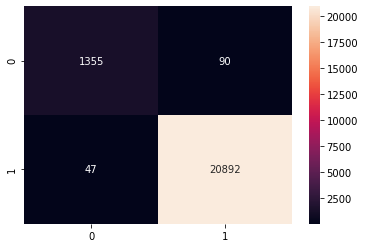

In [ ]:
# Use training and test split ratio of 80:20. On the test set, provide the Confusion Matrix.
# With what precision does the model predict the video to timeout (positive class will be 0 in this case)?
# You can use all the features or use a subset of the features as obtained using the approaches in Q1.

import seaborn as sns
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_true = [float(row.QoE_JT) for row in predictions.select("QoE_JT").collect()]
y_pred = [float(row.predictedLabel) for row in predictions.select("predictedLabel").collect()]
print(classification_report(y_true, y_pred))
sns.heatmap(confusion_matrix(y_true, y_pred),annot=True,fmt="d") 

Area Under Curve :  0.9677358238323185


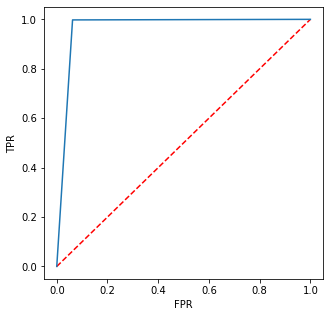

In [ ]:
# Question 2.2 Plot the ROC curve and provide the Area under the Curve (AUC) of the model.

from sklearn.metrics import *
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_true, y_pred)
print("Area Under Curve : ",auc(fpr,tpr))
plt.figure(figsize=(5,5))
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

# **Question 03 Visualization:**

Text(0, 0.5, '$p$')

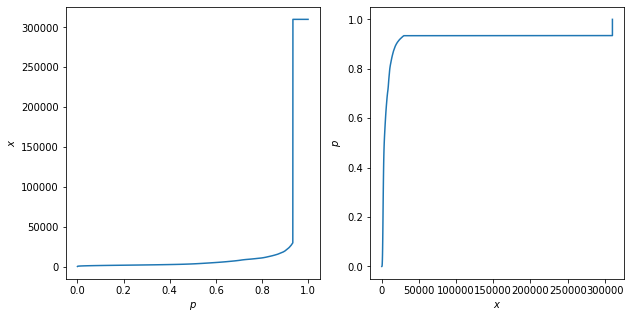

In [ ]:
# Question 3.1: Plot the CDF (Cumulative distribution function) for the variable “join_time”.
# This variable gives the startup delay (in milliseconds)for every YouTube video session.
# What percentage of videos play with join_time of less than 10 seconds?
import numpy as np
join_time = sorted([int(row.join_time) for row in data.select("join_time").collect()])

# calculate the proportional values of samples
p = 1. * np.arange(len(join_time)) / (len(join_time) - 1)

# plot the sorted data:
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(121)
ax1.plot(p, join_time)
ax1.set_xlabel('$p$')
ax1.set_ylabel('$x$')

ax2 = fig.add_subplot(122)
ax2.plot(join_time, p)
ax2.set_xlabel('$x$')
ax2.set_ylabel('$p$')


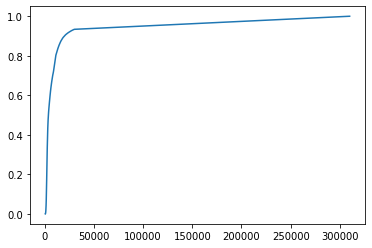

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

num_bins = np.unique(join_time)
counts, bin_edges = np.histogram (join_time, bins=num_bins)
cdf = np.cumsum (counts)
plt.plot (bin_edges[1:], cdf/cdf[-1])
plt.show()